# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [3]:
git=GitHub(token,repo_owner,repo_name,branch)
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

# Loading Benchmark

In [5]:
start_date=datetime.datetime(2020,1,1)
today=datetime.datetime.today()
days=(today-start_date).days
remaining=days%500
numbers_of_table=days//500
tickers=Binance.get_market_cap()['Ticker'].iloc[:40].to_list()
temp_end=start_date
scope_prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    scope_prices=scope_prices.combine_first(data)
    
temp_end=(today-datetime.timedelta(remaining))
data=Binance.get_price(tickers,temp_end)
scope_prices=scope_prices.combine_first(data)
scope_prices=scope_prices.sort_index()
scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
scope_prices.index=pd.to_datetime(scope_prices.index)
tickers2=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()
prices=scope_prices[tickers2]
returns=np.log(1+prices.pct_change(fill_method=None))
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na].sort_index()
dataframe=prices[with_no_na].sort_index()
dataframe.index=pd.to_datetime(dataframe.index)
returns_to_use.index=pd.to_datetime(returns_to_use.index)
returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

month=list(sorted(set(returns_to_use.index + pd.offsets.BMonthEnd(0))))
#month_end=pd.to_datetime(mrat_wo_na.index)
month = pd.to_datetime(month)

idx1 = pd.Index(returns_to_use.iloc[:-1].index)
idx2 = pd.Index(month)
closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]

dates_end=list(closest_dates)
dates_end.insert(0,returns_to_use.index[1])
dates_end.append(returns_to_use.index[-1])
dates_end=sorted(list(set(dates_end)))
dates_end.pop(0)
dates_end=sorted(list(set(dates_end)))

results={}

if 'USDCUSDT' in returns_to_use.columns:
    
    cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

else:

    cash=[]
# gold_positions=np.where(returns_to_use.columns=='GOLD.PA')[0][0]
#om_limit=np.where(returns_to_use.columns=='OMUSDT')[0][0]

for i in range(len(dates_end)-1):
    
    try:
        dataset=returns_to_use.loc[dates_end[i]:dates_end[i+1]]        
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        
        optimal=risk.optimize(objective='minimum_variance',constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00}#,
                                                                       ])# {'type': 'eq', 'fun': lambda weights: weights[gold_positions]-0.00}])
        
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
        pass

rolling_optimization=pd.DataFrame(results,index=dataframe.columns).T
rolling_optimization.loc[dates_end[0]]=1/len(dataframe.columns)
rolling_optimization=rolling_optimization.sort_index()

performance_model=pd.DataFrame()

In [6]:
results=(rebalanced_dynamic_quantities(dataframe,rolling_optimization.iloc[:-2])*dataframe)
drift=results.copy()

for col in drift.columns:
    drift[col]=drift[col]/results.sum(axis=1)
performance_model['Fund']=results.sum(axis=1)
performance_model['Bitcoin']=dataframe['BTCUSDT']
#performance['Mantra']=dataframe['OMUSDT']

performance_model_pct=performance_model.copy()
performance_model_pct=performance_model_pct.pct_change(fill_method=None)
last_weights=rolling_optimization.loc[dates_end[-3]]
weights_bench=pd.DataFrame(drift.iloc[-1])
weights_bench.columns=['Weights Model']

# Importing Data

In [8]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [9]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [11]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
quantities_api=Binance.binance_api.user_asset()

current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [14]:
# trade_history=pd.read_excel('Trades USDT.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))

In [15]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

TRXUSDT 0
BTCUSDT 1
TRXUSDT 2
BNBUSDT 3
ETHUSDT 4
SOLUSDT 5
BNBUSDT 6
USDTTRY 7
JASMYUSDT 8
BNBUSDT 9
BBUSDT 10
USDTTRY 11
BNBUSDT 12
USDTTRY 13
TRXUSDT 14
USDTTRY 15
JASMYUSDT 16
BNBUSDT 17
BBUSDT 18
OMUSDT 19
OMUSDT 20
OMUSDT 21
TRXUSDT 22
BTCUSDT 23
OMUSDT 24
BTCUSDT 25
TRXUSDT 26
TRXUSDT 27
BBUSDT 28
BNBUSDT 29
TRXUSDT 30
BTCUSDT 31
TRXUSDT 32
BTCUSDT 33
MKRUSDT 34
BTCUSDT 35
MKRUSDT 36
EURUSDT 37
EURUSDT 38
BBUSDT 39
BNBUSDT 40
JASMYUSDT 41
PEPEUSDT 42
NOTUSDT 43
NOTUSDT 44
NOTUSDT 45
BBUSDT 46
BBUSDT 47
PEPEUSDT 48
JASMYUSDT 49
BTCUSDT 50
BTCUSDT 51
TRXUSDT 52
BTCUSDT 53
BNBUSDT 54
BTCUSDT 55
BNBUSDT 56
BTCUSDT 57
BNBUSDT 58
BTCUSDT 59
BNBUSDT 60
BTCUSDT 61
BNBUSDT 62
BNBUSDT 63
BTCUSDT 64
BNBUSDT 65
JASMYUSDT 66
JASMYUSDT 67
ENSUSDT 68
ARUSDT 69
BTCUSDT 70
UMAUSDT 71
BTCUSDT 72
UMAUSDT 73
ETHUSDT 74
XRPUSDT 75
BTCUSDT 76
XRPUSDT 77
BTCUSDT 78
NEARUSDT 79
BTCUSDT 80
LPTUSDT 81
BTCUSDT 82
NEARUSDT 83
EURUSDT 84
BTCUSDT 85
INJUSDT 86
BTCUSDT 87
FETUSDT 88
EURUSDT 89
EURUSDT 90
EURU

In [16]:
price

,Date(UTC),Market,Type,Price,Amount,Total,Fee,Fee Coin,Pair Price,Price in USDT,Total in USDT,Pair Quantity
0,2025-08-31 22:32:23,TRXUSDT,BUY,0.342500,200.600000,68.705500,0.000056,BNB,0.342962,0.342500,68.705500,200.600000
1,2025-08-31 22:32:07,BTCUSDT,SELL,109079.990000,0.000630,68.720394,0.000056,BNB,109075.714221,109079.990000,68.720394,0.000630
2,2025-08-31 22:28:53,TRXUSDT,BUY,0.342418,2022.600000,692.574470,0.000569,BNB,0.343100,0.342418,692.574485,2022.600000
3,2025-08-31 22:27:52,BNBUSDT,SELL,867.280000,0.019000,16.478320,0.000014,BNB,866.834667,867.280000,16.478320,0.019000
4,2025-08-31 22:27:32,ETHUSDT,SELL,4462.540000,0.069300,309.254022,0.000254,BNB,4467.496043,4462.540000,309.254022,0.069300
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-05-09 22:32:57,TRXEUR,BUY,0.118983,205.828142,25.000000,0.510000,EUR,1.077905,0.128252,26.397894,205.828142
116,2024-05-09 19:36:50,UMAEUR,BUY,3.803499,6.438808,25.000000,0.510000,EUR,1.077517,4.098334,26.388383,6.438808
117,2024-05-06 23:27:11,ETHEUR,BUY,2912.268956,0.008407,25.000000,0.510000,EUR,1.076000,3133.601397,26.344908,0.008407
118,2024-05-06 23:15:38,BTCEUR,BUY,59899.712723,0.000409,25.000000,0.510000,EUR,1.076100,64458.080861,26.353686,0.000409


In [17]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

historical_positions.rename(columns={'TRYUSDT': 'USDTTRY'}, inplace=True)

In [18]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_64348\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [19]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()


USDUSDT not retrieved


In [20]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:80].to_list()

In [21]:
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
holding_tickers.remove("USDCUSDT")
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],weights_bench,realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Weights Model','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100
pnl.sort_values(by='Weights',ascending=False).round(4)

,Average Cost,Book Cost,Price in USDT,Weights,Weights Model,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,2111.4816,2202.6207,0.9999,1.0000,-146.9409,238.08,91.1391,4.3164
TRXUSDT,0.2647,872.3899,1152.4672,0.5232,0.5695,-12.2962,280.08,267.7838,12.6823
BTCUSDT,68795.5284,565.5529,948.9429,0.4308,0.4305,13.0697,383.39,396.4597,18.7764
OMUSDT,1.1299,526.3213,100.8469,0.0458,0.0000,0.0000,-425.47,-425.4700,-20.1503
ETHUSDT,3654.5327,0.1328,0.1661,0.0001,0.0000,55.9949,0.03,56.0249,2.6533
BBUSDT,0.5169,0.0000,0.0000,0.0000,0.0000,-84.8224,0.00,-84.8224,-4.0172
JASMYUSDT,0.0303,0.0000,0.0000,0.0000,0.0000,-172.9781,0.00,-172.9781,-8.1923
USDUSDT,0.0036,0.0000,0.0000,0.0000,0.0000,-25.7525,0.00,-25.7525,-1.2196
XRPUSDT,0.5511,0.0000,0.0000,0.0000,0.0000,-6.1147,0.00,-6.1147,-0.2896
BNBUSDT,677.1600,0.0438,0.0587,0.0000,0.0000,-16.1456,0.01,-16.1356,-0.7642


In [22]:
selling_amount=pd.DataFrame()

selling_amount['Portfolio']=pnl['Weights']
selling_amount['Model']=pnl['Weights Model']
selling_amount['Positions']=pnl['Price in USDT']

selling_amount['Model Positions']=selling_amount['Model']*selling_amount.loc['Total','Positions']
selling_amount['Spread']=selling_amount['Model Positions']-selling_amount['Positions']
selling_amount.sort_values(by='Model',ascending=False).round(2)

,Portfolio,Model,Positions,Model Positions,Spread
Total,1.00,1.00,2202.62,2202.62,-0.00
TRXUSDT,0.52,0.57,1152.47,1254.42,101.95
BTCUSDT,0.43,0.43,948.94,948.20,-0.74
BNBUSDT,0.00,0.00,0.06,0.00,-0.06
ETHUSDT,0.00,0.00,0.17,0.00,-0.17
JASMYUSDT,0.00,0.00,0.00,0.00,0.00
USDUSDT,0.00,0.00,0.00,0.00,0.00
XRPUSDT,0.00,0.00,0.00,0.00,0.00
USDCUSDT,0.00,0.00,0.03,0.00,-0.03
BBUSDT,0.00,0.00,0.00,0.00,0.00


In [23]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [24]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [25]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [26]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')
inventory_weights.pop('USDCUSDT')


if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [27]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [28]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [30]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: 1b80ff64bb26c1e4668bd1bb4eb98dd785e64137)
✅ File pushed/updated successfully!


In [31]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [32]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [33]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [34]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 75e241381ff407d7d398df27d319837e43a1c837)
✅ File pushed/updated successfully!


In [35]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [36]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [37]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()
cols=quantities.columns[quantities.columns!='USDCUSDT']

for col in cols:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [38]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [39]:
# pnl_history['Total']

In [40]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [41]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [42]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [43]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in cols:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [44]:
pnl_history['Total']

2024-09-23   -247.226270
2024-09-24   -303.288508
2024-09-25   -320.535015
2024-09-26   -234.835798
2024-09-27   -218.316677
                 ...    
2025-09-07   -530.345430
2025-09-08   -519.915805
2025-09-09   -512.401494
2025-09-10   -480.331600
2025-09-11    226.812591
Name: Total, Length: 354, dtype: float64

<Axes: >

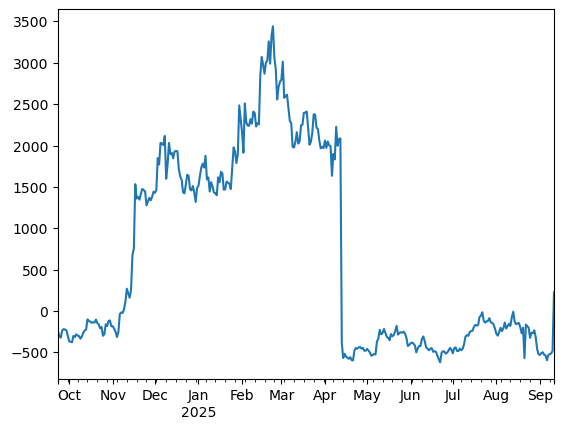

In [45]:
pnl_history['Total'].plot()

In [46]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:]

2025-08-12    106.411481
2025-08-13     65.040275
2025-08-14   -116.944819
2025-08-15    -33.788702
2025-08-16      9.416085
2025-08-17      6.186404
2025-08-18    -51.411836
2025-08-19    -74.026161
2025-08-20     67.755802
2025-08-21   -368.329352
2025-08-22    405.182289
2025-08-23    -17.678735
2025-08-24    -20.768624
2025-08-25   -121.271345
2025-08-26     62.086247
2025-08-27     -5.984666
2025-08-28     34.510654
2025-08-29    -80.680751
2025-08-30   -142.309648
2025-08-31    -64.917376
2025-09-01     -9.128634
2025-09-02     21.807289
2025-09-03     11.513615
2025-09-04    -30.406007
2025-09-05     -7.870188
2025-09-06    -59.574293
2025-09-07     64.103747
2025-09-08     10.429624
2025-09-09      7.514311
2025-09-10     32.069894
2025-09-11    707.144191
Name: Total, dtype: float64

In [47]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']

var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-370.82733707497374, -950.5160328166937)

In [48]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [49]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [50]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [51]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [52]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [53]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [54]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

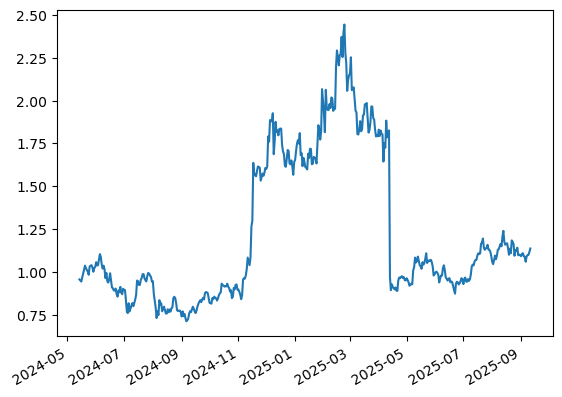

In [55]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

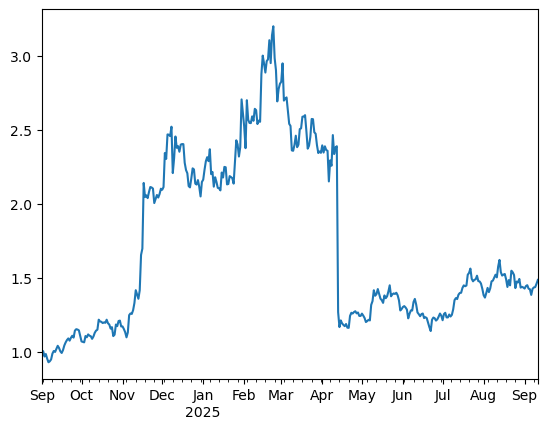

In [56]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [58]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [338]:
days=120
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [339]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [342]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.4085
TRXUSDT,0.3316
WBETHUSDT,0.2118
BCHUSDT,0.0468
ALGOUSDT,0.0012
ETHUSDT,0.0000
CFXUSDT,0.0000
OMUSDT,0.0000
TIAUSDT,0.0000
IMXUSDT,0.0000


In [343]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.408382
TRXUSDT,0.333040
WBETHUSDT,0.210377
BCHUSDT,0.048201


In [344]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))

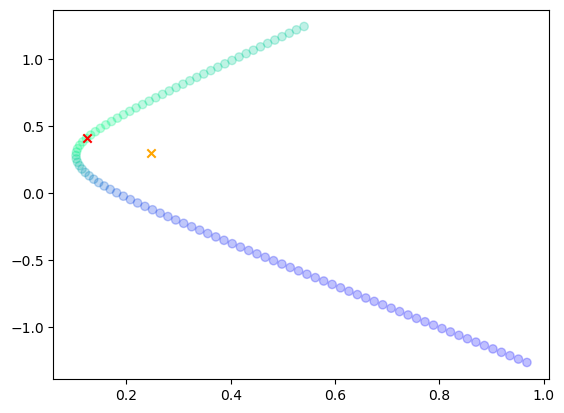

In [345]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [346]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [347]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1152.4672,0.5232,0.0548,0.4684
BTCUSDT,948.9429,0.4308,0.0000,0.4308
OMUSDT,100.8469,0.0458,0.0000,0.0458
ETHUSDT,0.1661,0.0001,0.0000,0.0001
SOLUSDT,0.1056,0.0000,0.0000,0.0000
BNBUSDT,0.0587,0.0000,0.0271,-0.0271
USDCUSDT,0.0333,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
PAXGUSDT,0.0000,0.0000,0.7096,-0.7096
WBETHUSDT,0.0000,0.0000,0.0904,-0.0904


### Current results

In [349]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [350]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BNBUSDT,0.481157
TRXUSDT,0.342819
ETHUSDT,0.176024


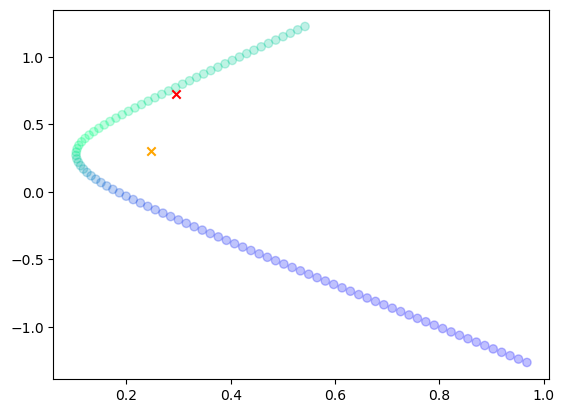

In [351]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [352]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
TRXUSDT,1152.4672,0.5232,0.3428,0.1804
BTCUSDT,948.9429,0.4308,0.0000,0.4308
OMUSDT,100.8469,0.0458,0.0000,0.0458
ETHUSDT,0.1661,0.0001,0.1760,-0.1759
SOLUSDT,0.1056,0.0000,0.0000,0.0000
BNBUSDT,0.0587,0.0000,0.4812,-0.4811
USDCUSDT,0.0333,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [354]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [355]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
portfolio_perf['Model']=performance_model_pct['Fund']

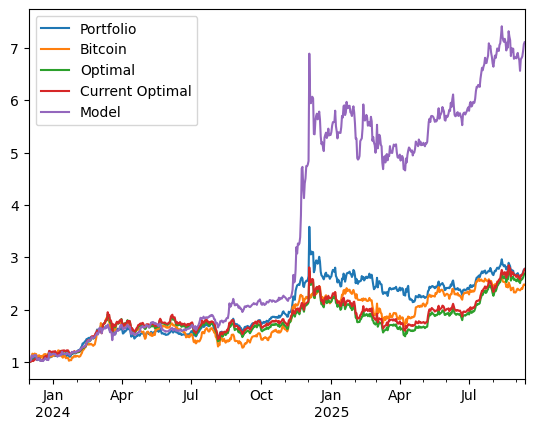

In [356]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [357]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

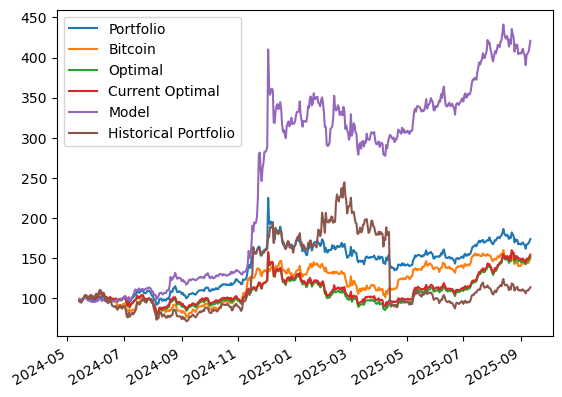

In [358]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

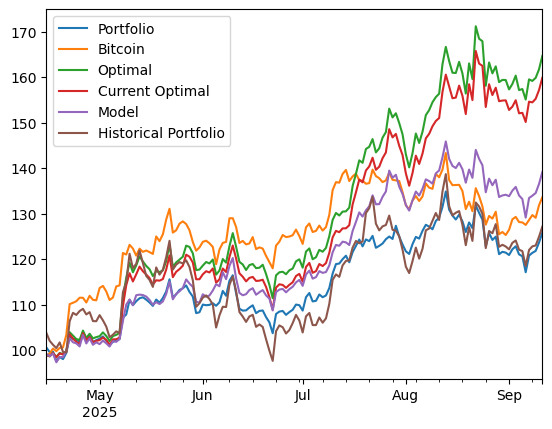

In [359]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

<Axes: >

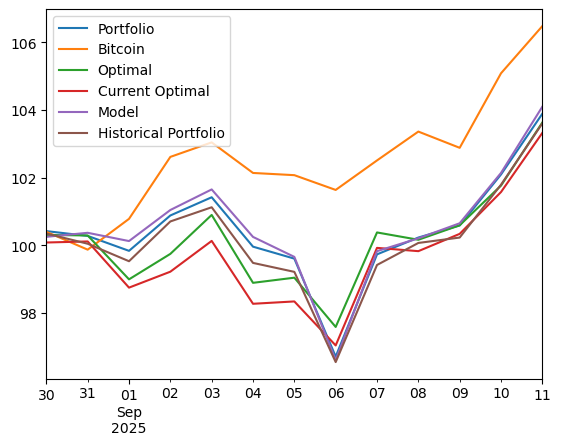

In [360]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100).plot()

In [361]:
((1+current_perf.loc['2025-08-30':]).cumprod()*100)

,Portfolio,Bitcoin,Optimal,Current Optimal,Model,Historical Portfolio
2025-08-30,100.425362,100.404183,100.312874,100.088355,100.256523,100.353789
2025-08-31,100.282969,99.876884,100.296515,100.119430,100.375068,100.051951
2025-09-01,99.841889,100.787165,98.999720,98.754829,100.131022,99.535062
2025-09-02,100.887023,102.618109,99.752394,99.225940,101.048870,100.710311
2025-09-03,101.425344,103.046817,100.903056,100.135555,101.656804,101.129679
2025-09-04,99.965451,102.143595,98.896811,98.277688,100.253501,99.485482
2025-09-05,99.611808,102.078191,99.048676,98.347058,99.663249,99.220782
2025-09-06,96.716287,101.641846,97.592795,97.046481,96.614945,96.554921
2025-09-07,99.737878,102.513832,100.385503,99.929408,99.832474,99.424509
2025-09-08,100.234766,103.366171,100.169360,99.832733,100.211609,100.075140


## Volatilities

In [363]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.305705
 dtype: float64,
 0.30570455657533924)

In [364]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.247048
 dtype: float64,
 0.24704778709704298)

In [365]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.405285
Bitcoin            0.402865
Optimal            0.404403
Current Optimal    0.400491
Model              0.491580
dtype: float64

In [366]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.19413530052328565

In [563]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-0.9683565511723834

<Axes: >

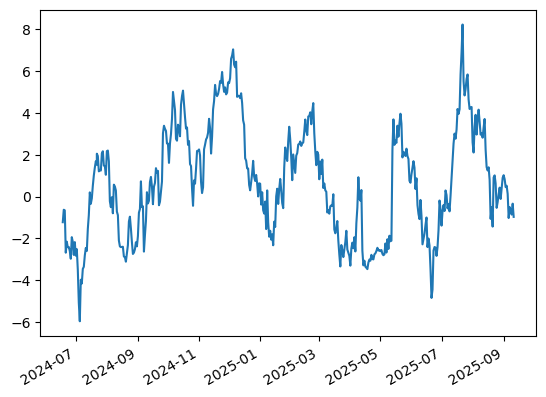

In [368]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [369]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.221824413311924

## Risk Contribution

In [371]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,14.8036,0.3748,0.1685,0.2063
WBETHUSDT,14.4880,0.3451,0.1385,0.2067
TRXUSDT,8.4824,0.2268,0.0959,0.1309
BCHUSDT,1.9309,0.0533,0.0067,0.0467
Portfolio,39.7050,1.0000,0.4095,0.5905


In [372]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,17.441631,0.460459,0.249949,0.210510
ETHUSDT,11.819525,0.296123,0.104272,0.191850
TRXUSDT,8.731502,0.243418,0.108558,0.134861
Portfolio,37.992658,1.000000,0.462779,0.537221


In [373]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,13.244252,0.517278,0.357857,0.159421
BTCUSDT,4.100801,0.370085,0.197130,0.172955
OMUSDT,-2.780387,0.112637,0.038369,0.074267
Portfolio,14.564666,1.000000,0.593356,0.406644


# Value At Risk

## Historical

### Optimal Weights

In [377]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.03818399602001988, -0.049113746531399737)

### Current Weights

In [379]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.03462391858780133, -0.040330414991659125)

In [380]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [381]:
var=historical_var.iloc[row]
var

TRXUSDT     -0.013557
BTCUSDT     -0.017193
OMUSDT      -0.004066
ETHUSDT     -0.000000
SOLUSDT     -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT     0.000000
Portfolio   -0.034816
Name: 2025-05-23 00:00:00, dtype: float64

In [382]:
cvar=historical_var.iloc[:row+1].mean()
cvar

TRXUSDT     -0.021352
BTCUSDT     -0.015100
OMUSDT      -0.003879
ETHUSDT      0.000000
SOLUSDT      0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.040330
dtype: float64

## Parametric

### Optimal Weights

In [385]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.04479982316676856, -0.055487511602500324)

### Current Weights

In [387]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.03620389993422109, -0.04484089837091101)

## Multivariate

### Optimal Weights

In [390]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.04073632148839062, -0.04708715831964696)

### Current Weights

In [392]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.034964363080085735, -0.039242506253799964)

In [393]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

TRXUSDT     -0.018890
BTCUSDT     -0.011906
OMUSDT      -0.004145
Portfolio   -0.034941
dtype: float64

In [394]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

TRXUSDT     -0.018098
BTCUSDT     -0.012793
OMUSDT      -0.004552
Portfolio   -0.035444
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [398]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0408589934519122, -0.04704864983345461)

### Current Weights

In [400]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.035533262583766566, -0.040691572573772546)

In [401]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [404]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.04118099531384048, -0.04803164089095237)

### Current Weights

In [406]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.036071415247259785, -0.04157295013899581)

In [407]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [410]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06355568678861202, -0.07685913815900823)

### Current Weights

In [412]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06644979160553402, -0.07995294309422514)

In [413]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [416]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [417]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.04553783340319778, -0.05184269665204386)

### Current Weights

In [419]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.036219863181744874, -0.04159253827144769)

In [420]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [421]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.024548,-0.018521,-0.013315,-0.018890,-0.018146
BTCUSDT,-0.013930,-0.012346,-0.009549,-0.011906,-0.013156
OMUSDT,-0.002931,-0.004132,-0.002967,-0.004145,-0.005105
Portfolio,-0.041410,-0.034999,-0.025830,-0.034941,-0.036407


In [422]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
TRXUSDT,-0.022638,-0.018875,-0.012806,-0.018098,-0.017916
BTCUSDT,-0.018126,-0.012134,-0.010281,-0.012793,-0.013775
OMUSDT,-0.001204,-0.004472,-0.003019,-0.004552,-0.005184
Portfolio,-0.041968,-0.035481,-0.026106,-0.035444,-0.036875


## VaR Violation

In [424]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.023484,-0.047850,-0.042967,-0.022140
2024-01-15,-0.023484,-0.048280,-0.044078,0.019813
2024-01-16,-0.023484,-0.047433,-0.042996,0.001502
2024-01-17,-0.023484,-0.048058,-0.042514,-0.012502
2024-01-18,-0.023484,-0.048030,-0.043748,-0.002158
...,...,...,...,...
2025-09-08,-0.049288,-0.059367,-0.058136,-0.002153
2025-09-09,-0.049288,-0.059325,-0.056674,0.004276
2025-09-10,-0.049288,-0.059473,-0.056640,0.011660
2025-09-11,-0.049288,-0.057357,-0.057058,0.018322


In [425]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-15,-0.047429,-0.048190,-0.045018,-0.036856
2023-12-16,-0.047429,-0.048259,-0.045879,0.010609
2023-12-17,-0.047429,-0.048865,-0.047496,-0.013505
2023-12-18,-0.047429,-0.048962,-0.046125,0.007113
2023-12-19,-0.047429,-0.046451,-0.047934,-0.004283
...,...,...,...,...
2025-09-08,-0.043727,-0.047508,-0.051949,0.004982
2025-09-09,-0.030487,-0.039086,-0.038660,0.003561
2025-09-10,-0.030487,-0.037249,-0.036976,0.014985
2025-09-11,-0.030487,-0.038086,-0.036869,0.017583


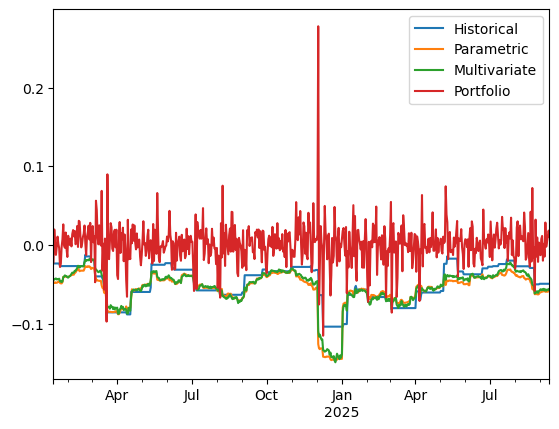

In [426]:
var_data.plot()
plt.show()

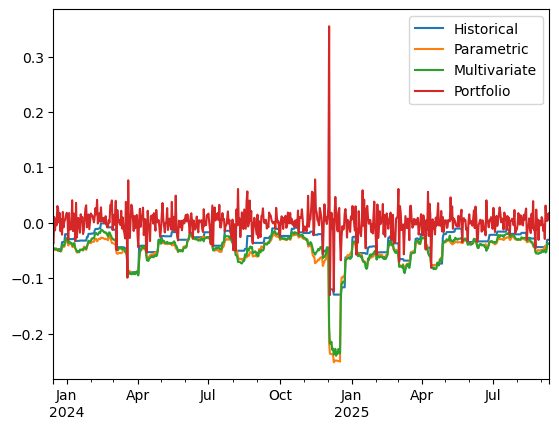

In [427]:
current_var_data.plot()
plt.show()


In [428]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.032895,0.014803,0.014803
Kupiec Stat,4.23773,21.673328,21.673328
P-value,0.039535,0.000003,0.000003


In [429]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.067398,0.010972,0.012539
Kupiec Stat,3.683629,29.57548,26.599655
P-value,0.054949,0.0,0.0


# Principal Component Analysis

## Historical PCA

In [432]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.82187443, 0.08278566, 0.03845974, 0.02917995, 0.02770022])

In [433]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.017689
ADAUSDT      0.017639
ALGOUSDT     0.021416
APTUSDT      0.018845
ARBUSDT      0.028129
ATOMUSDT     0.017482
AVAXUSDT     0.020879
BCHUSDT      0.010647
BNBUSDT      0.008715
BONKUSDT     0.027209
BTCUSDT      0.007169
CFXUSDT      0.024989
CRVUSDT      0.022091
DOGEUSDT     0.022510
DOTUSDT      0.018923
ENSUSDT      0.021222
ETCUSDT      0.018059
ETHUSDT      0.016518
FDUSDUSDT    0.000095
FETUSDT      0.021555
FILUSDT      0.019743
FLOKIUSDT    0.028060
GRTUSDT      0.022376
HBARUSDT     0.020377
ICPUSDT      0.019313
IMXUSDT      0.026402
INJUSDT      0.026406
LDOUSDT      0.025969
LINKUSDT     0.021518
LTCUSDT      0.014462
MKRUSDT      0.015655
NEARUSDT     0.023202
OMUSDT       0.023969
OPUSDT       0.026634
PAXGUSDT     0.000025
PEPEUSDT     0.026052
QNTUSDT      0.014179
RAYUSDT      0.023696
SEIUSDT      0.023839
SHIBUSDT     0.017889
SOLUSDT      0.017457
STXUSDT      0.021662
SUIUSDT      0.021537
TIAUSDT      0.027868
TRXUSDT      0.005161
UNIUSDT   

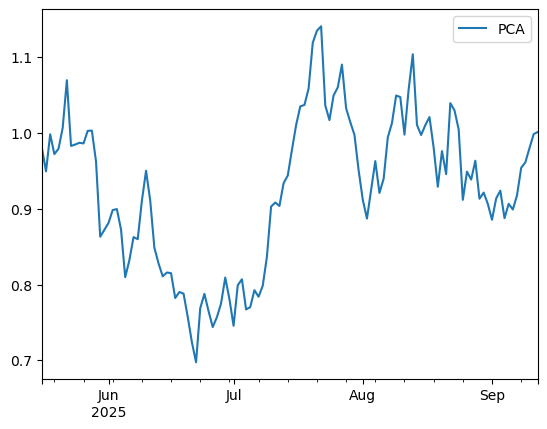

In [434]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

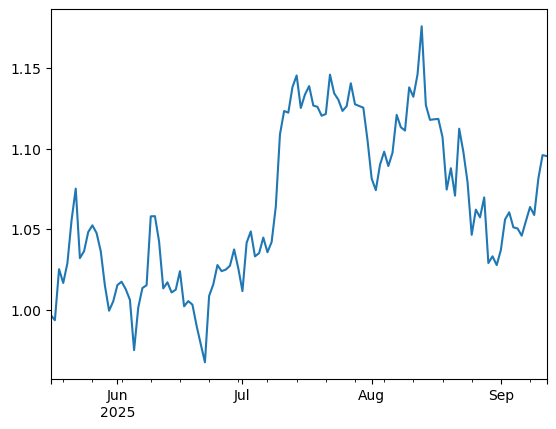

In [435]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [436]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SHIBUSDT     0.120476
NEARUSDT     0.124991
FILUSDT      0.128679
DOTUSDT      0.135735
VETUSDT      0.141886
ATOMUSDT     0.147666
GRTUSDT      0.153079
ICPUSDT      0.157708
ENSUSDT      0.179479
DOGEUSDT     0.188191
AVAXUSDT     0.195930
ADAUSDT      0.200660
APTUSDT      0.201868
STXUSDT      0.202942
PEPEUSDT     0.204243
IMXUSDT      0.206096
ETCUSDT      0.207302
ETHUSDT      0.207468
WBETHUSDT    0.208169
dtype: float64

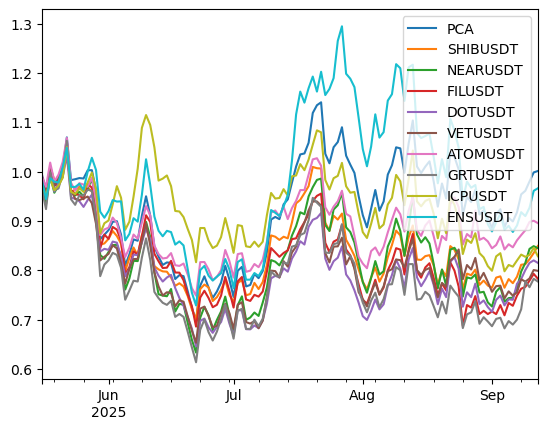

In [437]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

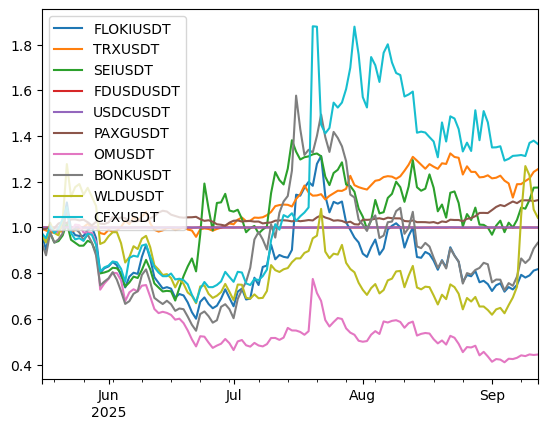

In [438]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [440]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75479837, 0.15659283, 0.04139395, 0.02712376, 0.02009109])

In [441]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

TRXUSDT     0.042442
BTCUSDT     0.062131
OMUSDT      0.272505
ETHUSDT     0.148145
SOLUSDT     0.156377
BNBUSDT     0.079934
PEPEUSDT    0.238023
PAXGUSDT    0.000443
Name: PC1, dtype: float64

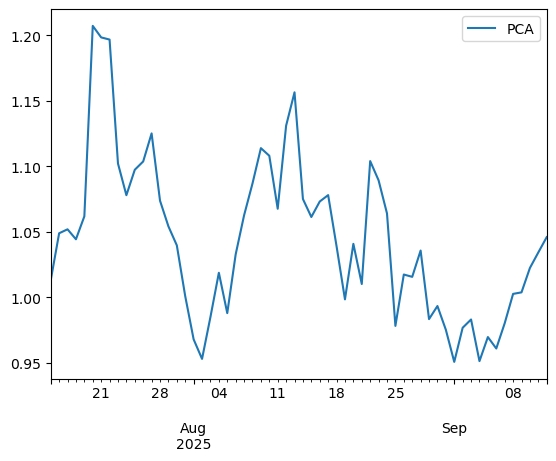

In [442]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

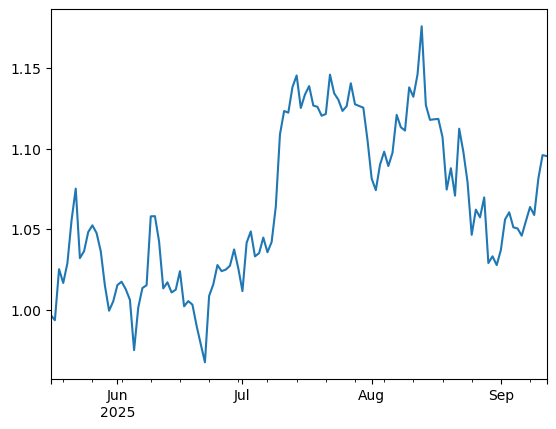

In [443]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [444]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA         0.000000
ETHUSDT     0.224348
SOLUSDT     0.234535
PEPEUSDT    0.237450
BNBUSDT     0.266408
BTCUSDT     0.294519
TRXUSDT     0.358359
OMUSDT      0.374049
PAXGUSDT    0.410345
dtype: float64

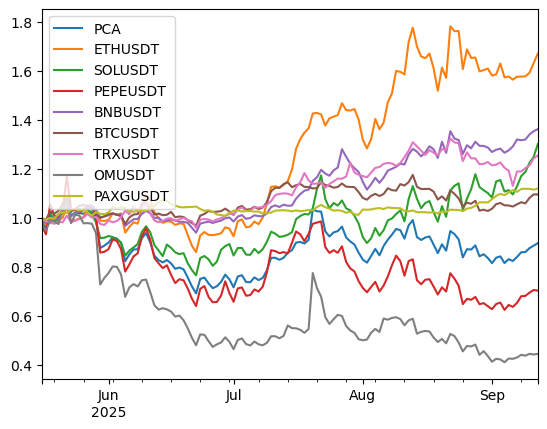

In [445]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [447]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    1.922711
SOLUSDT     1.299410
ETHUSDT     1.108663
OMUSDT      1.010736
BTCUSDT     1.000000
BNBUSDT     0.671466
TRXUSDT     0.341371
PAXGUSDT    0.029990
Name: BTCUSDT, dtype: float64

In [448]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT    2.176555
SOLUSDT     1.975886
OMUSDT      1.974363
ETHUSDT     1.785772
BNBUSDT     1.000592
BTCUSDT     1.000000
TRXUSDT     0.765258
PAXGUSDT    0.155769
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [450]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [451]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
PEPEUSDT,0.425020
OMUSDT,0.181454
PAXGUSDT,0.166336
BTCUSDT,0.156265
SOLUSDT,0.140531
ETHUSDT,0.134585
TRXUSDT,0.047300
BNBUSDT,0.039229


### Regression to PCA

In [453]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.4648663354580218

In [454]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

PCA         1.000000
ETHUSDT     0.907920
BNBUSDT     0.825654
BTCUSDT     0.800684
SOLUSDT     0.612979
PEPEUSDT    0.356297
TRXUSDT     0.279474
OMUSDT      0.157484
PAXGUSDT    0.023437
dtype: float64

In [455]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

PAXGUSDT    3.135281
BTCUSDT     2.061124
BNBUSDT     1.443400
TRXUSDT     1.211992
PCA         1.000000
PEPEUSDT    0.916191
ETHUSDT     0.905143
OMUSDT      0.884777
SOLUSDT     0.851088
dtype: float64

### Correlation Matrix

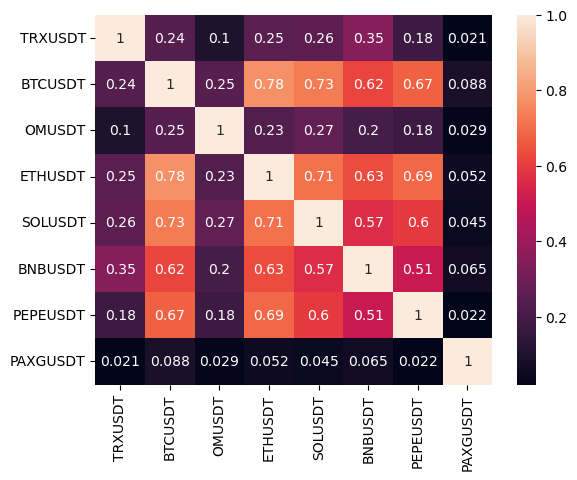

In [457]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

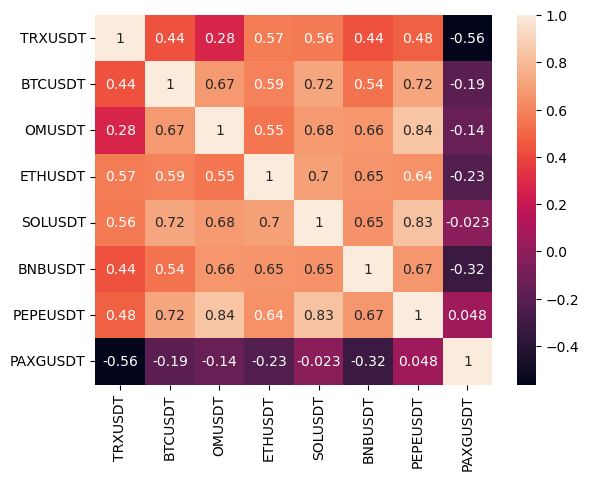

In [458]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [459]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [460]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

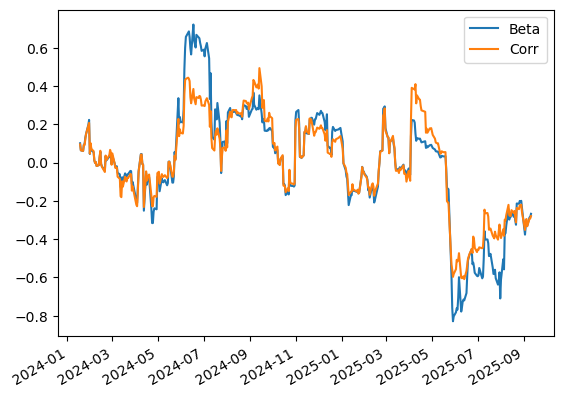

In [461]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [463]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,TRXUSDT,BTCUSDT,OMUSDT,ETHUSDT,SOLUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2023-12-14,0.000000,0.107613,0.104338,0.000000,0.000000,0.522522,0.000000,0.265527
2023-12-28,0.000000,0.000000,0.000000,0.000000,0.331762,0.668238,0.000000,0.000000
2024-01-11,0.000000,0.000000,0.560261,0.439739,0.000000,0.000000,0.000000,0.000000
2024-01-25,0.379492,0.000000,0.104622,0.000000,0.000000,0.000000,0.000000,0.515886
2024-02-08,0.066364,0.000000,0.047113,0.191144,0.041760,0.000000,0.000000,0.653620
2024-02-22,0.705974,0.000000,0.000000,0.164223,0.000000,0.129803,0.000000,0.000000
2024-03-07,0.000000,0.000000,0.000000,0.020832,0.156080,0.000000,0.046602,0.776486
2024-03-21,0.000000,0.000000,0.462471,0.000000,0.000000,0.471815,0.065714,0.000000
2024-04-04,0.000000,0.000920,0.019296,0.000000,0.000000,0.113904,0.000000,0.865879
2024-04-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [464]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [465]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TIAUSDT,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT
2025-02-04,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0
2025-03-06,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.097217,0.000000,0.000000,...,0.0,0.018212,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0
2025-04-05,0.000000,0.0,0.0,0.0,0.0,0.121906,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0
2025-05-05,0.000002,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0
2025-06-04,0.795659,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0
2025-07-04,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.805192,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0
2025-08-03,0.000411,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.023836,...,0.0,0.589128,0.0,0.0,0.0,0.047485,0.0,0.000000,0.0318,0.0
2025-09-02,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0
2025-09-12,0.007442,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.453738,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.017672,0.0000,0.0


In [466]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

PAXGUSDT    0.957537
LINKUSDT    0.039976
LDOUSDT     0.002487
LTCUSDT     0.000000
MKRUSDT     0.000000
NEARUSDT    0.000000
Name: 2025-09-02 00:00:00, dtype: float64

In [467]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
